**Importing Skin Cancer Data**

To do: Take necessary actions to read the data
Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential




In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
128


**Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Create a dataset**

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 128 files belonging to 9 classes.
Using 25 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Visualize the data**

Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [9]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


In [10]:
img = image.load_img('/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000139.jpg')

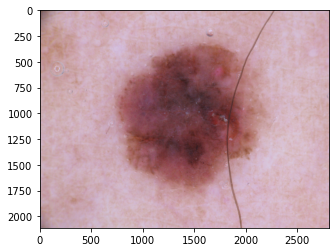

In [11]:
plt.imshow(img)

In [12]:
plt.imread('/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000139.jpg')

array([[[ 95,  72,  80],
        [ 95,  72,  80],
        [ 96,  73,  81],
        ...,
        [188, 152, 156],
        [188, 152, 156],
        [188, 151, 158]],

       [[ 95,  72,  80],
        [ 96,  73,  81],
        [ 99,  74,  80],
        ...,
        [188, 152, 156],
        [188, 152, 156],
        [188, 152, 156]],

       [[ 98,  73,  79],
        [ 99,  74,  80],
        [100,  75,  81],
        ...,
        [191, 152, 157],
        [190, 151, 156],
        [189, 150, 155]],

       ...,

       [[146, 119, 134],
        [146, 119, 134],
        [145, 121, 137],
        ...,
        [211, 169, 181],
        [210, 168, 180],
        [210, 168, 180]],

       [[144, 119, 138],
        [143, 118, 137],
        [143, 118, 137],
        ...,
        [211, 168, 185],
        [211, 168, 185],
        [210, 167, 184]],

       [[143, 120, 140],
        [142, 119, 139],
        [141, 118, 138],
        ...,
        [211, 170, 186],
        [211, 168, 185],
        [210, 167, 184]]

In [13]:
 AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Create the model**

In [14]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [15]:
normalization_layer = layers.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.21207549 0.70684093


In [17]:
num_classes = 9

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


**Compile the model**

Choose an appropirate optimiser and loss function for model training

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

**Train the model**

In [20]:
epochs= 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
) 

Epoch 1/20
281/281 [==============================] - 285s 1s/step - loss: 1.7165 - accuracy: 0.3462 - val_loss: 2.3424 - val_accuracy: 0.3600
Epoch 2/20
281/281 [==============================] - 284s 1s/step - loss: 1.2256 - accuracy: 0.5437 - val_loss: 3.0597 - val_accuracy: 0.4000
Epoch 3/20
281/281 [==============================] - 287s 1s/step - loss: 0.9496 - accuracy: 0.6498 - val_loss: 3.3125 - val_accuracy: 0.2800
Epoch 4/20
281/281 [==============================] - 274s 976ms/step - loss: 0.6841 - accuracy: 0.7583 - val_loss: 4.4415 - val_accuracy: 0.3600
Epoch 5/20
281/281 [==============================] - 275s 979ms/step - loss: 0.5019 - accuracy: 0.8247 - val_loss: 3.8161 - val_accuracy: 0.5600
Epoch 6/20
281/281 [==============================] - 274s 976ms/step - loss: 0.3793 - accuracy: 0.8679 - val_loss: 3.6556 - val_accuracy: 0.4000
Epoch 7/20
281/281 [==============================] - 272s 970ms/step - loss: 0.3191 - accuracy: 0.8923 - val_loss: 4.9092 - val_accu

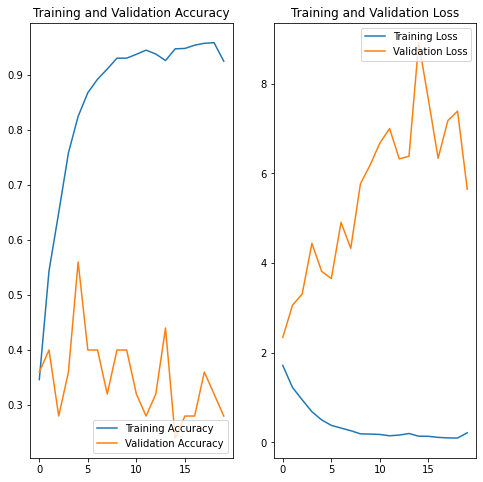

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Clearly we can say Model is overfit 
thats why we do augmantation

In [22]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) 

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDE71DA4FD0>: 100%|██████████| 500/500 [00:27<00:00, 18.13 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDE71E05AD0>: 100%|██████████| 500/500 [00:28<00:00, 17.69 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDE71D9B350>: 100%|██████████| 500/500 [00:23<00:00, 21.15 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7FDE700460D0>: 100%|██████████| 500/500 [01:57<00:00,  4.24 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FDE70054D10>: 100%|██████████| 500/500 [01:33<00:00,  5.34 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDE7224FD10>: 100%|██████████| 500/500 [00:23<00:00, 21.33 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FDE73B9B850>: 100%|██████████| 500/500 [00:55<00:00,  9.08 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDE73AFCED0>: 100%|██████████| 500/500 [00:23<00:00, 21.29 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDE73AB8310>: 100%|██████████| 500/500 [00:23<00:00, 20.90 Samples/s]


In [24]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

13500


In [25]:
path_list = [x for x in os.path.join(data_dir_train, '*','output', '*.jpg')]
path_list

['/',
 'c',
 'o',
 'n',
 't',
 'e',
 'n',
 't',
 '/',
 'g',
 'd',
 'r',
 'i',
 'v',
 'e',
 '/',
 'M',
 'y',
 'D',
 'r',
 'i',
 'v',
 'e',
 '/',
 'C',
 'o',
 'l',
 'a',
 'b',
 ' ',
 'N',
 'o',
 't',
 'e',
 'b',
 'o',
 'o',
 'k',
 's',
 '/',
 'S',
 'k',
 'i',
 'n',
 ' ',
 'c',
 'a',
 'n',
 'c',
 'e',
 'r',
 ' ',
 'I',
 'S',
 'I',
 'C',
 ' ',
 'T',
 'h',
 'e',
 ' ',
 'I',
 'n',
 't',
 'e',
 'r',
 'n',
 'a',
 't',
 'i',
 'o',
 'n',
 'a',
 'l',
 ' ',
 'S',
 'k',
 'i',
 'n',
 ' ',
 'I',
 'm',
 'a',
 'g',
 'i',
 'n',
 'g',
 ' ',
 'C',
 'o',
 'l',
 'l',
 'a',
 'b',
 'o',
 'r',
 'a',
 't',
 'i',
 'o',
 'n',
 '/',
 'T',
 'r',
 'a',
 'i',
 'n',
 '/',
 '*',
 '/',
 'o',
 'u',
 't',
 'p',
 'u',
 't',
 '/',
 '*',
 '.',
 'j',
 'p',
 'g']

In [26]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in os.path.join(data_dir_train, '*','output', '*.jpg')]
lesion_list_new

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

In [28]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))